In [1]:
# ====================================================
# STEP 1: Import Libraries (TensorFlow Only)
# ====================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# TensorFlow imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Check GPU availability
print("=" * 50)
print("TENSORFLOW ENVIRONMENT CHECK")
print("=" * 50)
print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")
print(f"Num GPUs: {len(tf.config.list_physical_devices('GPU'))}")

# Enable mixed precision for faster training (if GPU available)
if len(tf.config.list_physical_devices('GPU')) > 0:
    print("✅ GPU detected! Enabling mixed precision...")
    tf.keras.mixed_precision.set_global_policy('mixed_float16')
else:
    print("⚠️ No GPU detected. Using CPU.")

TENSORFLOW ENVIRONMENT CHECK
TensorFlow version: 2.20.0
GPU Available: []
Num GPUs: 0
⚠️ No GPU detected. Using CPU.


In [3]:
# ====================================================
# STEP 2: Load Data (Memory Optimized)
# ====================================================

def load_data(sample_size=50000):
    print("=" * 50)
    print(f"LOADING DATA (Sample: {sample_size:,} rows)")
    print("=" * 50)
    
    try:
        # Load training data
        print("\n📂 Reading train_transaction.csv...")
        train_df = pd.read_csv(
            "train_transaction.csv",
            nrows=sample_size,
            low_memory=True
        )
        print(f"✅ Train data loaded: {train_df.shape}")
        
        # Load test data
        print("\n📂 Reading test_transaction.csv...")
        test_sample = int(sample_size * 0.85)
        test_df = pd.read_csv(
            "test_transaction.csv",
            nrows=test_sample,
            low_memory=True
        )
        print(f"✅ Test data loaded: {test_df.shape}")
        
        # Optimize datatypes
        print("\n⚙️ Optimizing datatypes...")
        for col in train_df.select_dtypes(include=['float64']).columns:
            train_df[col] = train_df[col].astype('float32')
        for col in test_df.select_dtypes(include=['float64']).columns:
            test_df[col] = test_df[col].astype('float32')
            
    except FileNotFoundError as e:
        print(f"❌ Error: {e}")
        print("Please ensure the data files are in the correct path.")
        raise
    
    # Summary
    print("\n" + "=" * 50)
    print("DATA LOADING SUMMARY")
    print("=" * 50)
    print(f"Train shape: {train_df.shape}")
    print(f"Test shape: {test_df.shape}")
    
    train_memory = train_df.memory_usage(deep=True).sum() / 1024**2
    test_memory = test_df.memory_usage(deep=True).sum() / 1024**2
    print(f"\nMemory usage:")
    print(f"  Train: {train_memory:.2f} MB")
    print(f"  Test: {test_memory:.2f} MB")
    
    # Class distribution
    if 'isFraud' in train_df.columns:
        print("\n" + "=" * 50)
        print("CLASS DISTRIBUTION")
        print("=" * 50)
        class_dist = train_df['isFraud'].value_counts()
        print(f"Non-Fraud (0): {class_dist[0]:,} ({100*class_dist[0]/len(train_df):.2f}%)")
        print(f"Fraud (1): {class_dist[1]:,} ({100*class_dist[1]/len(train_df):.2f}%)")
        print(f"Imbalance ratio: {class_dist[0]/class_dist[1]:.2f}:1")
    
    return train_df, test_df

train_transaction, test_transaction = load_data(sample_size=50000)

LOADING DATA (Sample: 50,000 rows)

📂 Reading train_transaction.csv...
✅ Train data loaded: (50000, 394)

📂 Reading test_transaction.csv...
✅ Train data loaded: (50000, 394)

📂 Reading test_transaction.csv...
✅ Test data loaded: (42500, 393)

⚙️ Optimizing datatypes...
✅ Test data loaded: (42500, 393)

⚙️ Optimizing datatypes...

DATA LOADING SUMMARY
Train shape: (50000, 394)
Test shape: (42500, 393)

Memory usage:
  Train: 101.63 MB
  Test: 88.04 MB

CLASS DISTRIBUTION
Non-Fraud (0): 48,643 (97.29%)
Fraud (1): 1,357 (2.71%)
Imbalance ratio: 35.85:1

DATA LOADING SUMMARY
Train shape: (50000, 394)
Test shape: (42500, 393)

Memory usage:
  Train: 101.63 MB
  Test: 88.04 MB

CLASS DISTRIBUTION
Non-Fraud (0): 48,643 (97.29%)
Fraud (1): 1,357 (2.71%)
Imbalance ratio: 35.85:1


## 2. EXPLORATORY DATA ANALYSIS (EDA)

In [4]:
# ====================================================
# EDA: Missing Values Analysis
# ====================================================

def eda_report(train_df):
    print("=" * 50)
    print("EXPLORATORY DATA ANALYSIS")
    print("=" * 50)
    
    # Missing values
    missing_pct = (train_df.isnull().sum() / len(train_df) * 100).sort_values(ascending=False)
    print(f"\nTop 20 columns with missing values (%):")
    print(missing_pct[missing_pct > 0].head(20))
    
    # Summary statistics
    print("\n" + "=" * 50)
    print("SUMMARY STATISTICS")
    print("=" * 50)
    print(train_df.describe())
    
    return missing_pct

missing_pct = eda_report(train_transaction)

EXPLORATORY DATA ANALYSIS

Top 20 columns with missing values (%):
D7               95.288
dist2            93.290
D13              92.644
D12              91.806
D14              91.344
D6               90.350
D9               82.500
D8               82.500
M7               81.552
M8               81.552
M9               81.552
R_emaildomain    76.680
V153             75.574
V139             75.574
V140             75.574
V154             75.574
V151             75.574
V146             75.574
V145             75.574
V144             75.574
dtype: float64

SUMMARY STATISTICS
       TransactionID       isFraud  TransactionDT  TransactionAmt  \
count   5.000000e+04  50000.000000   5.000000e+04    50000.000000   
mean    3.012000e+06      0.027140   6.377990e+05      128.123215   
std     1.443390e+04      0.162493   3.229399e+05      213.075165   
min     2.987000e+06      0.000000   8.640000e+04        0.292000   
25%     2.999500e+06      0.000000   3.522868e+05       42.000000   
50% 

Computing correlations on sample data...

Number of numeric columns: 380

TOP 15 FEATURES CORRELATED WITH isFraud
V201    0.335542
V189    0.299736
V200    0.291913
V198    0.263671
V156    0.262075
V257    0.257523
V158    0.247926
V188    0.246906
V155    0.245714
V45     0.242658
V149    0.237780
V231    0.237673
V197    0.234355
V157    0.231962
V199    0.229055
Name: isFraud, dtype: float64

TOP 15 FEATURES CORRELATED WITH isFraud
V201    0.335542
V189    0.299736
V200    0.291913
V198    0.263671
V156    0.262075
V257    0.257523
V158    0.247926
V188    0.246906
V155    0.245714
V45     0.242658
V149    0.237780
V231    0.237673
V197    0.234355
V157    0.231962
V199    0.229055
Name: isFraud, dtype: float64


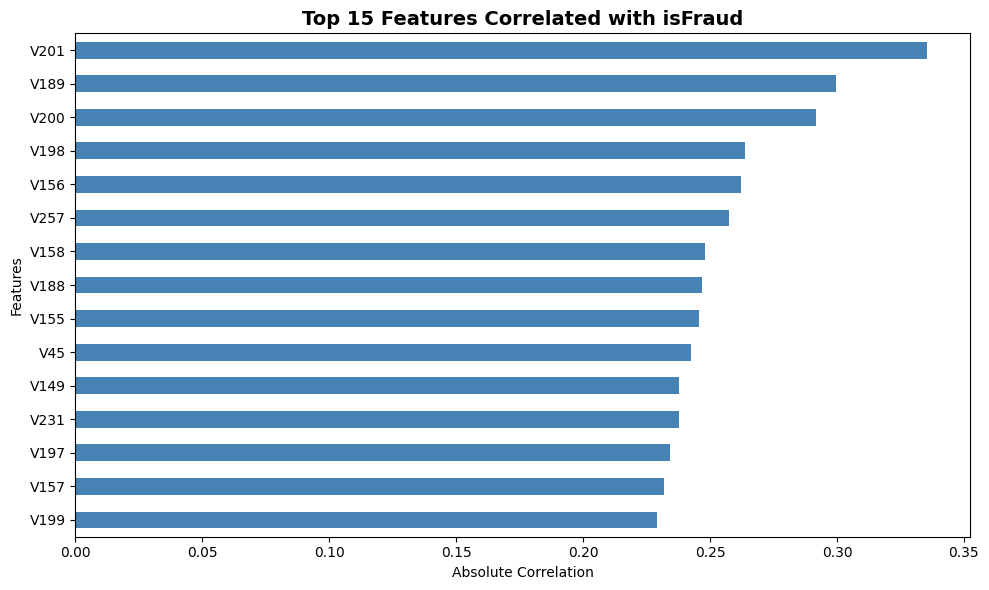

In [ ]:
print("Computing correlations")
sample_size = min(50000, len(train_transaction))
train_sample = train_transaction.sample(n=sample_size, random_state=42)

numeric_cols = train_sample.select_dtypes(include=[np.number]).columns.tolist()
print(f"\nNumber of numeric columns: {len(numeric_cols)}")

if 'isFraud' in numeric_cols:
    correlations = train_sample[numeric_cols].corr()['isFraud'].drop('isFraud').abs().sort_values(ascending=False)
    
    print("TOP 15 FEATURES CORRELATED WITH isFraud")
    print(correlations.head(15))
    
    plt.figure(figsize=(10, 6))
    correlations.head(15).plot(kind='barh', color='steelblue')
    plt.title('Top 15 Features Correlated with isFraud', fontsize=14, fontweight='bold')
    plt.xlabel('Absolute Correlation')
    plt.ylabel('Features')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

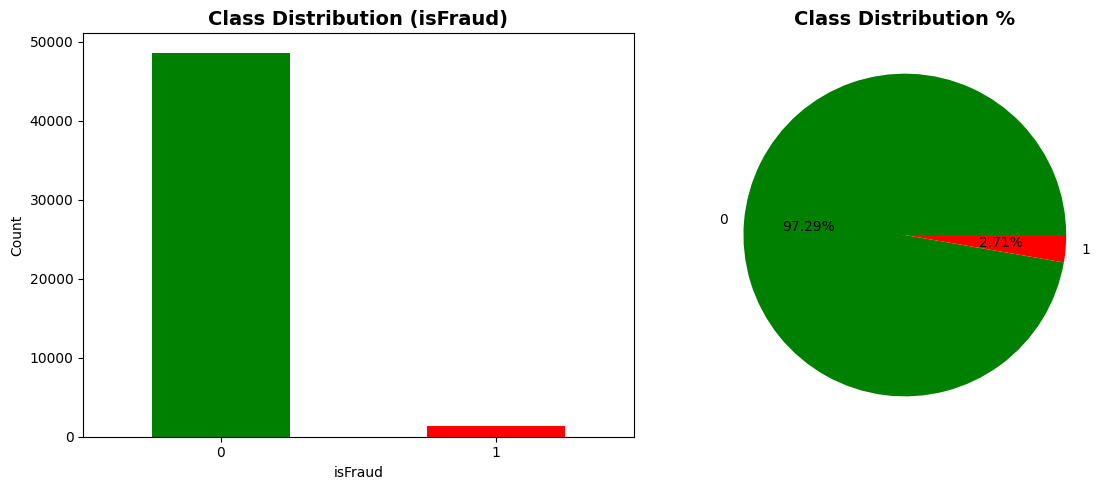

In [ ]:
# ====================================================
# EDA: Class Distribution Visualization
# ====================================================

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
train_transaction['isFraud'].value_counts().plot(kind='bar', color=['steelblue', 'coral'])
plt.title('Class Distribution (isFraud)', fontsize=14, fontweight='bold')
plt.xlabel('isFraud')
plt.ylabel('Count')
plt.xticks(rotation=0)

plt.subplot(1, 2, 2)
train_transaction['isFraud'].value_counts().plot(kind='pie', autopct='%1.2f%%', 
                                                   colors=['steelblue', 'coral'])
plt.title('Class Distribution (%)', fontsize=14, fontweight='bold')
plt.ylabel('')

plt.tight_layout()
plt.show()

## 3. DATA PREPROCESSING

In [5]:
# ====================================================
# STEP 3: Data Preprocessing (TensorFlow Only)
# ====================================================

def preprocess(train_df, test_df, target_col='isFraud'):
    print("=" * 50)
    print("DATA PREPROCESSING (TensorFlow)")
    print("=" * 50)
    
    # Separate features and target
    if target_col in train_df.columns:
        X_train_raw = train_df.drop(columns=[target_col])
        y_train = train_df[target_col].values.astype('float32')
    else:
        X_train_raw = train_df.copy()
        y_train = None
    
    X_test_raw = test_df.copy()
    
    # Store IDs
    test_id = X_test_raw['TransactionID'].copy() if 'TransactionID' in X_test_raw.columns else None
    
    # Drop ID columns
    id_cols = ['TransactionID', 'TransactionDT']
    for col in id_cols:
        if col in X_train_raw.columns:
            X_train_raw = X_train_raw.drop(columns=[col])
        if col in X_test_raw.columns:
            X_test_raw = X_test_raw.drop(columns=[col])
    
    # Identify column types
    numeric_cols = X_train_raw.select_dtypes(include=[np.number]).columns.tolist()
    categorical_cols = X_train_raw.select_dtypes(include=['object', 'category']).columns.tolist()
    
    print(f"\n📊 Numeric columns: {len(numeric_cols)}")
    print(f"📊 Categorical columns: {len(categorical_cols)}")
    
    # =========================================
    # IMPUTATION using TensorFlow/NumPy
    # =========================================
    print("\n" + "-" * 40)
    print("IMPUTATION (NumPy)")
    print("-" * 40)
    
    # Numeric imputation with median
    for col in numeric_cols:
        median_val = np.nanmedian(X_train_raw[col].values)
        X_train_raw[col] = X_train_raw[col].fillna(median_val)
        X_test_raw[col] = X_test_raw[col].fillna(median_val)
    print(f"✅ Imputed {len(numeric_cols)} numeric columns with median")
    
    # Categorical imputation with mode
    for col in categorical_cols:
        mode_val = X_train_raw[col].mode()[0] if len(X_train_raw[col].mode()) > 0 else 'UNKNOWN'
        X_train_raw[col] = X_train_raw[col].fillna(mode_val)
        X_test_raw[col] = X_test_raw[col].fillna(mode_val)
    print(f"✅ Imputed {len(categorical_cols)} categorical columns with mode")
    
    # =========================================
    # CATEGORICAL ENCODING (Manual Label Encoding)
    # =========================================
    print("\n" + "-" * 40)
    print("CATEGORICAL ENCODING")
    print("-" * 40)
    
    label_mappings = {}
    for col in categorical_cols:
        # Get unique values from both train and test
        unique_vals = pd.concat([X_train_raw[col].astype(str), X_test_raw[col].astype(str)]).unique()
        # Create mapping dictionary
        mapping = {val: idx for idx, val in enumerate(unique_vals)}
        label_mappings[col] = mapping
        
        # Apply mapping
        X_train_raw[col] = X_train_raw[col].astype(str).map(mapping)
        X_test_raw[col] = X_test_raw[col].astype(str).map(mapping)
    
    print(f"✅ Label encoded {len(categorical_cols)} categorical columns")
    
    # Convert to float32
    X_train_raw = X_train_raw.astype('float32')
    X_test_raw = X_test_raw.astype('float32')
    
    # =========================================
    # FEATURE SCALING using TensorFlow
    # =========================================
    print("\n" + "-" * 40)
    print("FEATURE SCALING (TensorFlow)")
    print("-" * 40)
    
    # Calculate mean and std from training data
    train_mean = np.mean(X_train_raw.values, axis=0)
    train_std = np.std(X_train_raw.values, axis=0)
    train_std = np.where(train_std == 0, 1, train_std)  # Avoid division by zero
    
    # Apply standardization
    X_train_scaled = ((X_train_raw.values - train_mean) / train_std).astype('float32')
    X_test_scaled = ((X_test_raw.values - train_mean) / train_std).astype('float32')
    
    print(f"✅ Scaled all features using StandardScaler (TensorFlow)")
    
    # Clean up
    del X_train_raw, X_test_raw
    import gc
    gc.collect()
    
    print("\n" + "=" * 50)
    print("PREPROCESSING COMPLETE")
    print("=" * 50)
    print(f"Final X_train shape: {X_train_scaled.shape}")
    print(f"Final X_test shape: {X_test_scaled.shape}")
    print(f"Final y_train shape: {y_train.shape if y_train is not None else 'N/A'}")
    
    return X_train_scaled, X_test_scaled, y_train, test_id, train_mean, train_std

X_train, X_test, y_train, test_ids, train_mean, train_std = preprocess(train_transaction, test_transaction)

DATA PREPROCESSING (TensorFlow)

📊 Numeric columns: 377
📊 Categorical columns: 14

----------------------------------------
IMPUTATION (NumPy)
----------------------------------------

📊 Numeric columns: 377
📊 Categorical columns: 14

----------------------------------------
IMPUTATION (NumPy)
----------------------------------------
✅ Imputed 377 numeric columns with median
✅ Imputed 14 categorical columns with mode

----------------------------------------
CATEGORICAL ENCODING
----------------------------------------
✅ Imputed 377 numeric columns with median
✅ Imputed 14 categorical columns with mode

----------------------------------------
CATEGORICAL ENCODING
----------------------------------------
✅ Label encoded 14 categorical columns

----------------------------------------
FEATURE SCALING (TensorFlow)
----------------------------------------
✅ Label encoded 14 categorical columns

----------------------------------------
FEATURE SCALING (TensorFlow)
-------------------------

In [6]:
# ====================================================
# STEP 4: Handle Class Imbalance (TensorFlow - Class Weights)
# ====================================================

def compute_class_weights(y):
    """Compute class weights for imbalanced data using TensorFlow/NumPy"""
    print("=" * 50)
    print("HANDLING CLASS IMBALANCE")
    print("=" * 50)
    
    print("\nClass distribution:")
    unique, counts = np.unique(y, return_counts=True)
    total = len(y)
    for u, c in zip(unique, counts):
        print(f"  Class {int(u)}: {c:,} ({100*c/total:.2f}%)")
    
    # Compute class weights (inverse frequency)
    n_samples = len(y)
    n_classes = len(unique)
    
    class_weights = {}
    for cls, count in zip(unique, counts):
        class_weights[int(cls)] = n_samples / (n_classes * count)
    
    print(f"\n📊 Class weights computed:")
    for cls, weight in class_weights.items():
        print(f"  Class {cls}: {weight:.4f}")
    
    return class_weights

class_weights = compute_class_weights(y_train)

HANDLING CLASS IMBALANCE

Class distribution:
  Class 0: 48,643 (97.29%)
  Class 1: 1,357 (2.71%)

📊 Class weights computed:
  Class 0: 0.5139
  Class 1: 18.4230


In [ ]:
# ====================================================
# Memory Status Check
# ====================================================
import gc
gc.collect()

print("=" * 50)
print("MEMORY STATUS")
print("=" * 50)
print(f"X_train: {X_train.nbytes / 1024**2:.2f} MB")
print(f"X_test: {X_test.nbytes / 1024**2:.2f} MB")
print(f"Total data in memory: {(X_train.nbytes + X_test.nbytes) / 1024**2:.2f} MB")

In [7]:
# ====================================================
# STEP 5: Train/Validation Split (TensorFlow)
# ====================================================

def train_val_split(X, y, val_size=0.2, seed=42):
    """Split data into train and validation sets using TensorFlow"""
    print("=" * 50)
    print("TRAIN/VALIDATION SPLIT")
    print("=" * 50)
    
    # Set seed
    np.random.seed(seed)
    
    n_samples = len(X)
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    val_samples = int(n_samples * val_size)
    
    val_indices = indices[:val_samples]
    train_indices = indices[val_samples:]
    
    X_train_split = X[train_indices]
    X_val_split = X[val_indices]
    y_train_split = y[train_indices]
    y_val_split = y[val_indices]
    
    print(f"Training set: {X_train_split.shape[0]:,} samples")
    print(f"Validation set: {X_val_split.shape[0]:,} samples")
    print(f"Feature dimension: {X_train_split.shape[1]}")
    
    return X_train_split, X_val_split, y_train_split, y_val_split

X_train_final, X_val, y_train_final, y_val = train_val_split(X_train, y_train, val_size=0.2)

TRAIN/VALIDATION SPLIT
Training set: 40,000 samples
Validation set: 10,000 samples
Feature dimension: 391
Training set: 40,000 samples
Validation set: 10,000 samples
Feature dimension: 391


In [8]:
# ====================================================
# STEP 6: Build Deep Learning Model (TensorFlow)
# ====================================================

def build_model(input_dim):
    """Build a deep neural network using TensorFlow/Keras"""
    print("=" * 50)
    print("BUILDING DEEP LEARNING MODEL")
    print("=" * 50)
    
    model = models.Sequential([
        # Input layer
        layers.Input(shape=(input_dim,)),
        
        # Hidden Layer 1
        layers.Dense(256, kernel_initializer='he_normal'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.3),
        
        # Hidden Layer 2
        layers.Dense(128, kernel_initializer='he_normal'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.3),
        
        # Hidden Layer 3
        layers.Dense(64, kernel_initializer='he_normal'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.2),
        
        # Hidden Layer 4
        layers.Dense(32, kernel_initializer='he_normal'),
        layers.Activation('relu'),
        
        # Output layer
        layers.Dense(1, activation='sigmoid', dtype='float32')
    ])
    
    # Compile model
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            keras.metrics.AUC(name='auc'),
            keras.metrics.Precision(name='precision'),
            keras.metrics.Recall(name='recall')
        ]
    )
    
    print("\n✅ TensorFlow Model built successfully!")
    print("\n" + "-" * 40)
    print("Model Architecture:")
    print("-" * 40)
    model.summary()
    
    return model

# Build model
input_dimension = X_train_final.shape[1]
model = build_model(input_dimension)

BUILDING DEEP LEARNING MODEL

✅ TensorFlow Model built successfully!

----------------------------------------
Model Architecture:
----------------------------------------


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │       100,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 145,409 (568.00 KB)

 Trainable params: 144,513 (564.50 KB)

 Non-trainable params: 896 (3.50 KB)

In [ ]:
# ====================================================
# STEP 7: Train Model (TensorFlow)
# ====================================================

def train_model(model, X_train, y_train, X_val, y_val, class_weights, epochs=50, batch_size=512):
    """Train the deep learning model using TensorFlow"""
    print("=" * 50)
    print("TRAINING MODEL")
    print("=" * 50)
    
    # Callbacks
    early_stopping = EarlyStopping(
        monitor='val_auc',
        patience=10,
        mode='max',
        restore_best_weights=True,
        verbose=1
    )
    
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )
    
    model_checkpoint = ModelCheckpoint(
        'best_fraud_model.keras',
        monitor='val_auc',
        mode='max',
        save_best_only=True,
        verbose=1
    )
    
    # Train model
    print(f"\n🚀 Training with {epochs} epochs, batch_size={batch_size}")
    print(f"📊 Using class weights to handle imbalance\n")
    
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        class_weight=class_weights,
        callbacks=[early_stopping, reduce_lr, model_checkpoint],
        verbose=1
    )
    
    print("\n✅ Training completed!")
    
    return history

# Train the model
history = train_model(
    model, 
    X_train_final, y_train_final, 
    X_val, y_val,
    class_weights=class_weights,
    epochs=50,
    batch_size=512
)

In [ ]:
# ====================================================
# STEP 8: Model Evaluation (TensorFlow Only)
# ====================================================

print("=" * 60)
print("MODEL EVALUATION")
print("=" * 60)

# Get predictions
y_val_pred_proba = model.predict(X_val, verbose=0).flatten()
y_val_pred = (y_val_pred_proba >= 0.5).astype(int)

# Evaluate using TensorFlow metrics
val_results = model.evaluate(X_val, y_val, verbose=0)
val_loss = val_results[0]
val_accuracy = val_results[1]
val_auc = val_results[2]
val_precision = val_results[3]
val_recall = val_results[4]

# Calculate F1 Score manually
f1 = 2 * (val_precision * val_recall) / (val_precision + val_recall + 1e-7)

# Confusion Matrix (manual calculation)
tp = np.sum((y_val_pred == 1) & (y_val == 1))
tn = np.sum((y_val_pred == 0) & (y_val == 0))
fp = np.sum((y_val_pred == 1) & (y_val == 0))
fn = np.sum((y_val_pred == 0) & (y_val == 1))

print(f"""
📈 VALIDATION PERFORMANCE
{'='*40}
Loss:       {val_loss:.4f}
Accuracy:   {val_accuracy:.4f}
AUC-ROC:    {val_auc:.4f}
Precision:  {val_precision:.4f}
Recall:     {val_recall:.4f}
F1-Score:   {f1:.4f}

🔢 CONFUSION MATRIX
{'='*40}
                Predicted
              |  0   |  1   |
Actual  0     | {tn:5d} | {fp:5d} |
        1     | {fn:5d} | {tp:5d} |

True Negatives:  {tn:,}
False Positives: {fp:,}
False Negatives: {fn:,}
True Positives:  {tp:,}
""")

In [ ]:
# ====================================================
# STEP 9: Training History Visualization
# ====================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Loss
axes[0, 0].plot(history.history['loss'], label='Train Loss', color='blue')
axes[0, 0].plot(history.history['val_loss'], label='Val Loss', color='orange')
axes[0, 0].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# AUC
axes[0, 1].plot(history.history['auc'], label='Train AUC', color='blue')
axes[0, 1].plot(history.history['val_auc'], label='Val AUC', color='orange')
axes[0, 1].set_title('Model AUC', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('AUC')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Accuracy
axes[1, 0].plot(history.history['accuracy'], label='Train Accuracy', color='blue')
axes[1, 0].plot(history.history['val_accuracy'], label='Val Accuracy', color='orange')
axes[1, 0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Precision & Recall
axes[1, 1].plot(history.history['precision'], label='Train Precision', color='green')
axes[1, 1].plot(history.history['val_precision'], label='Val Precision', color='lightgreen')
axes[1, 1].plot(history.history['recall'], label='Train Recall', color='red')
axes[1, 1].plot(history.history['val_recall'], label='Val Recall', color='salmon')
axes[1, 1].set_title('Precision & Recall', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Score')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# ====================================================
# STEP 10: ROC Curve & Confusion Matrix Visualization
# ====================================================

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Confusion Matrix Heatmap
cm = np.array([[tn, fp], [fn, tp]])
sns.heatmap(cm, annot=True, fmt=',d', cmap='Blues', ax=axes[0],
            xticklabels=['Pred: 0', 'Pred: 1'],
            yticklabels=['Actual: 0', 'Actual: 1'])
axes[0].set_title('Confusion Matrix', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Actual')
axes[0].set_xlabel('Predicted')

# 2. ROC Curve (Manual calculation without sklearn)
# Sort predictions and compute TPR/FPR
thresholds = np.linspace(0, 1, 100)
tpr_list = []
fpr_list = []

for thresh in thresholds:
    y_pred_thresh = (y_val_pred_proba >= thresh).astype(int)
    tp_t = np.sum((y_pred_thresh == 1) & (y_val == 1))
    fn_t = np.sum((y_pred_thresh == 0) & (y_val == 1))
    fp_t = np.sum((y_pred_thresh == 1) & (y_val == 0))
    tn_t = np.sum((y_pred_thresh == 0) & (y_val == 0))
    
    tpr_list.append(tp_t / (tp_t + fn_t + 1e-7))
    fpr_list.append(fp_t / (fp_t + tn_t + 1e-7))

axes[1].plot(fpr_list, tpr_list, color='darkorange', lw=2, label=f'ROC curve (AUC = {val_auc:.4f})')
axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
axes[1].fill_between(fpr_list, tpr_list, alpha=0.3, color='darkorange')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate', fontsize=12)
axes[1].set_ylabel('True Positive Rate', fontsize=12)
axes[1].set_title('ROC Curve', fontsize=14, fontweight='bold')
axes[1].legend(loc='lower right')
axes[1].grid(True, alpha=0.3)

# 3. Prediction Distribution
axes[2].hist(y_val_pred_proba[y_val == 0], bins=50, alpha=0.5, label='Non-Fraud', color='blue')
axes[2].hist(y_val_pred_proba[y_val == 1], bins=50, alpha=0.5, label='Fraud', color='red')
axes[2].set_xlabel('Predicted Probability', fontsize=12)
axes[2].set_ylabel('Count', fontsize=12)
axes[2].set_title('Prediction Distribution', fontsize=14, fontweight='bold')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# ====================================================
# STEP 11: Predict on Test Data & Create Submission
# ====================================================

print("=" * 50)
print("PREDICTING ON TEST DATA")
print("=" * 50)

# Predict probabilities on test data
test_predictions = model.predict(X_test, verbose=1).flatten()

# Create submission DataFrame
submission = pd.DataFrame({
    'TransactionID': test_ids,
    'isFraud': test_predictions
})

print(f"\n✅ Submission shape: {submission.shape}")
print(f"\n📊 Prediction statistics:")
print(submission['isFraud'].describe())

print(f"\n📋 Submission preview:")
print(submission.head(10))

# Save submission
submission.to_csv('./submission_dl_tensorflow.csv', index=False)
print("\n✅ Submission saved to 'submission_dl_tensorflow.csv'")

In [ ]:
# ====================================================
# STEP 12: Final Model Summary
# ====================================================

print("=" * 60)
print("📊 FINAL MODEL SUMMARY (TensorFlow Deep Learning)")
print("=" * 60)
print(f"""
Framework: TensorFlow {tf.__version__}
{'='*50}

Dataset Information:
--------------------
• Training samples: {len(X_train_final):,}
• Validation samples: {len(X_val):,}
• Test samples: {len(X_test):,}
• Number of features: {X_train_final.shape[1]}

Model Architecture:
-------------------
• Input Layer: {X_train_final.shape[1]} features
• Hidden Layer 1: 256 units (ReLU + BatchNorm + Dropout 0.3)
• Hidden Layer 2: 128 units (ReLU + BatchNorm + Dropout 0.3)
• Hidden Layer 3: 64 units (ReLU + BatchNorm + Dropout 0.2)
• Hidden Layer 4: 32 units (ReLU)
• Output Layer: 1 unit (Sigmoid)

Training Configuration:
-----------------------
• Optimizer: Adam (lr=0.001)
• Loss: Binary Crossentropy
• Class Weights: Applied for imbalance
• Early Stopping: patience=10 (monitor val_auc)
• Learning Rate Reduction: factor=0.5, patience=5

Performance Metrics:
--------------------
• Loss: {val_loss:.4f}
• Accuracy: {val_accuracy:.4f}
• AUC-ROC: {val_auc:.4f}
• Precision: {val_precision:.4f}
• Recall: {val_recall:.4f}
• F1-Score: {f1:.4f}

Output Files:
-------------
• submission_dl_tensorflow.csv - Test predictions
• best_fraud_model.keras - Best model checkpoint
""")
print("=" * 60)